## Initialization

In [20]:
# data processing
import numpy as np
import pandas as pd 
from collections import defaultdict

# data visualization
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()
import urllib.request


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#adjust filepath so that working directory is folder "recreating-residual-attention-network"
%pwd
%cd .. 

'/home/ecbm4040/recreating-residual-attention-network/nbks'

In [2]:
# # If using Google Colab
# from google.colab import drive
# BASE_PATH = '/content/drive'
# drive.mount(BASE_PATH)

# # change directory
# import os
# PROJECT_PATH = os.path.join(BASE_PATH, "MyDrive", "2021-09 Fall Semester", "ECBM 4040 Neural Network Deep Learning", "Project", "recreating-residual-attention-network")
# os.chdir(PROJECT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Import created modules
from src.utils import generate_data

# Modelling

In [24]:
INPUT_SHAPE, NUM_CLASS, train_ds, val_ds, test_ds, _ = generate_data.get_cifar10()
BATCH_SIZE = 256
N_EPOCH = 10
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# # Use tensorflow keras to download dataset and split to train / test
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# # Rescale array (images) from 0-255 to 0-1 
# x_train = x_train.astype("float32") / 255.0
# x_test = x_test.astype("float32") / 255.0

In [17]:
INPUT_SHAPE = x_train.shape[1:]
NUM_CLASS = y_train.shape[1]
BATCH_SIZE = 128
N_EPOCH = 10

In [18]:
# Get the pretrained ResNet layers; include_top=False to change the dense layers
from tensorflow.keras.applications.resnet50 import ResNet50
transfer_layers = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Look at the layers - architecture for confirmation
transfer_layers.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [21]:
# Assemble model - add last layers to CIFAR 10
ran_model = models.Sequential()
ran_model.add(transfer_layers)
ran_model.add(layers.Flatten())
ran_model.add(layers.BatchNormalization())
ran_model.add(layers.Dense(64, activation='relu'))
ran_model.add(layers.Dropout(0.5))
ran_model.add(layers.BatchNormalization())
ran_model.add(layers.Dense(32, activation='relu'))
ran_model.add(layers.Dropout(0.5))
ran_model.add(layers.BatchNormalization())
ran_model.add(layers.Dense(10, activation='softmax'))

In [26]:
res50_model = ran_model

res50_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history = res50_model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH, verbose=1)

Epoch 1/10
157/157 [==============================] - 43s 130ms/step - loss: 2.1891 - accuracy: 0.2617 - val_loss: 3.5981 - val_accuracy: 0.1000
Epoch 2/10
157/157 [==============================] - 18s 116ms/step - loss: 1.2625 - accuracy: 0.6126 - val_loss: 5.0523 - val_accuracy: 0.1000
Epoch 3/10
157/157 [==============================] - 18s 115ms/step - loss: 1.0178 - accuracy: 0.6997 - val_loss: 4.3506 - val_accuracy: 0.1012
Epoch 4/10
157/157 [==============================] - 18s 113ms/step - loss: 0.8835 - accuracy: 0.7458 - val_loss: 2.6535 - val_accuracy: 0.1624
Epoch 5/10
157/157 [==============================] - 18s 113ms/step - loss: 0.7731 - accuracy: 0.7790 - val_loss: 2.1388 - val_accuracy: 0.4095
Epoch 6/10
157/157 [==============================] - 18s 114ms/step - loss: 0.6946 - accuracy: 0.8059 - val_loss: 1.7299 - val_accuracy: 0.5487
Epoch 7/10
157/157 [==============================] - 18s 114ms/step - loss: 0.6689 - accuracy: 0.8118 - val_loss: 0.9489 - val_ac

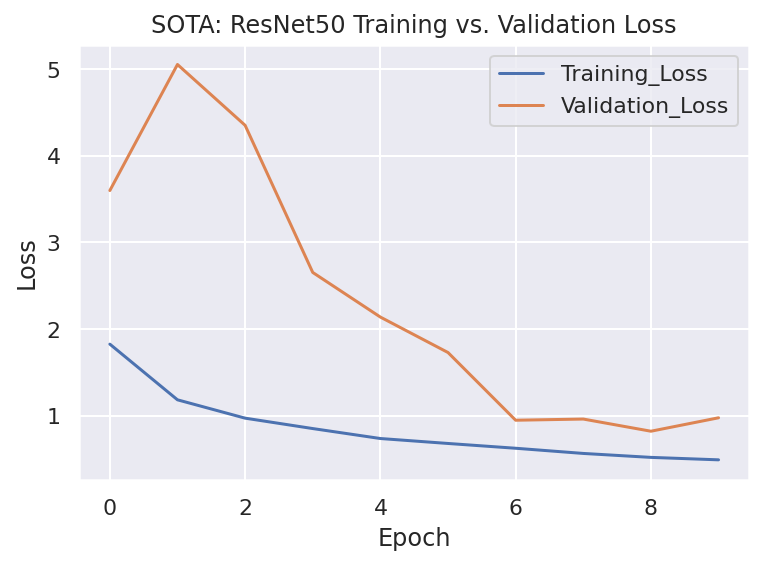

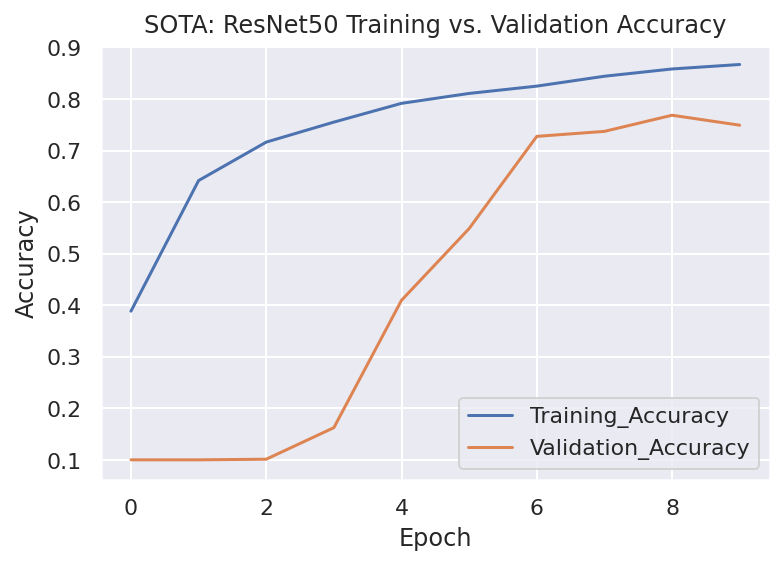

In [38]:
#ResNet Model Plots
#Loss curve
plt.figure()
plt.plot(history.history['loss'],label='Training_Loss')
plt.plot(history.history['val_loss'],label='Validation_Loss')
plt.title("SOTA: ResNet50 Training vs. Validation Loss")
plt.legend()
plt.ylabel('Loss')
plt.xlabel("Epoch")

plt.savefig("fig1.png")
plt.show()

plt.figure()
#Plot Training vs. Validation Accuracy curve for same model
plt.plot(history.history['accuracy'],label='Training_Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation_Accuracy')
plt.title("SOTA: ResNet50 Training vs. Validation Accuracy")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel("Epoch")

plt.savefig("fig2.png")

plt.show()

# Save model

In [35]:
#model filename to save
from datetime import datetime
#include training params in model name


%cd /home/ecbm4040/recreating-residual-attention-network/data/models
%pwd


model_filepath = '/home/ecbm4040/recreating-residual-attention-network/data/models'
model_filename = 'cifar10_res50SOTA_10epoch' + '_model_' + 'EPOCHS_'+ str(N_EPOCH) + str(BATCH_SIZE) + str(datetime.now) + '.h5'
# model_filepath = 'C:\\Users\\JacobNye\\Documents\\GitHub\\recreating-residual-attention-network\\data\\models\\'
# #model file path default is data

/home/ecbm4040/recreating-residual-attention-network/data/models


In [36]:
#Save Model 

res50_model.save(model_filename)

In [37]:
#test loading model
from tensorflow import keras
model = keras.models.load_model(model_filepath)
